In [1]:
import os
import numpy as np
import pandas as pd

from scipy.io import loadmat
from scipy.signal import butter, filtfilt

import matplotlib.pyplot as plt

EEG_FOLDER = f'../datasets/EEG_data_for_Mental_Attention_State_Detection'

trial = 4
channel = 'F4'


# 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'

# Util Methods

## Visualize the data

### Spikes Visualization

In [2]:
EEG_SPIKES = f'{EEG_FOLDER}/EEG_spikes'

def load_preprocessed_spikes(trial, channel):
    def append_zeros_to_fix_size(filename, size=6):
        # remove .npz
        filename = filename[:-4]
        filename = ('0' * (size-len(filename))) + filename
        return filename

    resonators_dir = f'{EEG_SPIKES}/{trial}/{channel}'
    return {
        append_zeros_to_fix_size(f0):
            np.load(f'{resonators_dir}/{clk_freq}/{f0}')['spikes'].astype(np.int8)
        for clk_freq in os.listdir(resonators_dir)
        for f0 in os.listdir(f'{resonators_dir}/{clk_freq}')
    }


def spikes_to_bins(spikes, window=195_000):
    num_bins = (len(spikes) // window) + 1
    bins = np.zeros(num_bins, dtype=np.int32)
    for j in range(num_bins):
        bins[j] = np.sum(spikes[j*window:(j+1)*window])
    return bins


def all_spikes2bins(full_spikes_data, window=195_000):
    return {
        f0: spikes_to_bins(spikes, window)
        for f0, spikes in full_spikes_data.items()
    }


def normalize_arr(arr):
    # return arr
    return (arr-np.min(arr))/(np.max(arr)-np.min(arr))


def sum_n_remove_dc(arr):
    return arr - np.min(arr)
    # for i in range(len(arr)):
    #     arr[i] = arr[i] - np.sum(arr[i])
    # return arr
    # arr = np.sum(arr, axis=0)[:-5]
    # return normalize_arr(arr)
    # arr = arr - np.min(arr)
    # return arr / np.max(arr)

def spikes_data2eeg_bands(spikes_data):
    # return {
    #     # '0. Delta': sum(normalize_arr(spikes_data[f])
    #     #                      for f in ['00.657', '01.523', '02.120', '02.504', '03.490']) / 5,
    #     '1. Theta': sum(normalize_arr(spikes_data[f])
    #                          for f in ['04.604', '05.755', '06.791', '08.000']) / 4,
    #     '2. Alpha': sum(normalize_arr(spikes_data[f])
    #                          for f in ['08.058', '09.065', '10.072', '11.885', '14.000']) / 5,
    #     '3. Beta':  sum(normalize_arr(spikes_data[f])
    #                          for f in ['15.108', '17.266', '19.424', '21.583', '25.468']) / 5,
    #     '4. Gamma': sum(normalize_arr(spikes_data[f])
    #                          # for f in ['36.259', '40.791', '45.324', '53.482', '63.000']) / 5
    #                          for f in ['36.259', '40.791']) / 2
    # }
    return {f: sum_n_remove_dc(spikes_data[f][:-5]) for f in ['15.108', '17.266', '19.424', '21.583', '25.468']}
    return {
        # '0. Delta': sum(normalize_arr(spikes_data[f])
        #                      for f in ['00.657', '01.523', '02.120', '02.504', '03.490']) / 5,
        # '1. Theta': sum_n_remove_dc([spikes_data[f]/3
        #                      for f in ['04.604', '05.755', '06.791']]),
        # '2. Alpha': sum_n_remove_dc([spikes_data[f]/5
        #                      for f in ['08.058', '09.065', '10.072', '11.885', '14.000']]),
        '3. Beta':  sum_n_remove_dc([spikes_data[f]/4
                             # for f in ['15.108', '17.266', '19.424', '21.583', '25.468']]),
                             for f in ['15.108', '19.424', '21.583', '25.468']]),
        # '4. Gamma': sum_n_remove_dc([spikes_data[f]/2
        #                      # for f in ['36.259', '40.791', '45.324', '53.482', '63.000']) / 5
        #                      for f in ['36.259', '40.791']]),
    }

def standarize_arr(arr):
    for i in range(len(arr)):
        arr[i] = (arr[i] - np.mean(arr[i])) / np.std(arr[i])
    return arr


def normalize_columns(arr):
    """
    Normalizes each column of a 2D NumPy array so that the minimum value in each column is 0 and the maximum is 1.

    Args:
    - arr: A 2D NumPy array with shape (n, k).

    Returns:
    - A normalized version of arr with the same shape.
    """
    # Find the minimum and maximum values for each column
    col_mins = np.min(arr, axis=0)
    col_maxs = np.max(arr, axis=0)

    # Make sure there are no divisions by zero
    col_ranges = np.where(col_maxs == col_mins, 1, col_maxs - col_mins)

    # Normalize each column by subtracting its minimum and dividing by its range
    return (arr - col_mins) / col_ranges

def spikes_dict2spectogram(
        output_spikes,
):
    spikes_heatmap = pd.DataFrame.from_dict(output_spikes)
    spikes_heatmap = spikes_heatmap.reindex(sorted(spikes_heatmap.columns), axis=1).T
    spikes_heatmap_data = spikes_heatmap.to_numpy()

    # spikes_heatmap_data = normalize_columns(spikes_heatmap_data)
    return spikes_heatmap_data

def plot_heatmap(heatmap_data, y_labels, annotate, title=None):
    fig, ax = plt.subplots(figsize=(14, 5))
    im = ax.imshow(
        heatmap_data,
        cmap='jet',
        aspect='auto',
        origin='lower',
        vmin=np.min(heatmap_data),
        vmax=np.max(heatmap_data),
    )
    ax.set_yticks(np.arange(len(y_labels)), labels=y_labels)

    # Loop over data dimensions and create text annotations.
    if annotate:
        for i in range(len(heatmap_data)):
            for j in range(len(heatmap_data[i])):
                text = ax.text(j, i,  f'{heatmap_data[i, j]:.4f}',
                               rotation=90,
                               ha="center", va="center", color="white")

    if title:
        ax.set_title(title)
    fig.tight_layout()
    fig.colorbar(im, ax=ax, label='Interactive colorbar')
    plt.show()

In [3]:
example_spikes_channel = load_preprocessed_spikes(trial, channel)

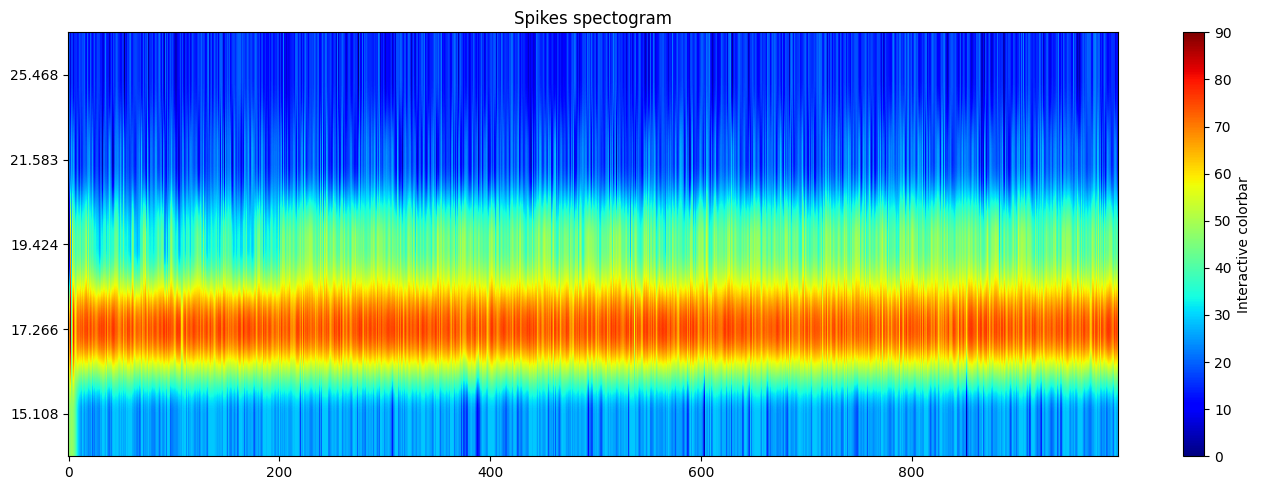

In [4]:
eeg_bands = spikes_data2eeg_bands(all_spikes2bins(example_spikes_channel, window=25_000))
spikes_spectogram = spikes_dict2spectogram(eeg_bands)
bins=int(spikes_spectogram.shape[1])
plot_heatmap(spikes_spectogram, eeg_bands.keys(), annotate=False, title='Spikes spectogram')

In [83]:
spikes_spectogram.shape

(4, 251)

 ### FFT Visualize

In [5]:
data_root = f'{EEG_FOLDER}/EEG_Data'


def plot_spectrogram(data, fs, fmin, fmax):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    Sxx, freqs, bins, im = plt.specgram(data, NFFT=256, Fs=fs,
                                         noverlap=128, cmap='jet')
    plt.ylim(fmin, fmax)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    # plt.title(channel + f' Spectrogram {channel_name}({fmin} - {fmax}) Hz')
    plt.imshow(Sxx, aspect='auto',
               cmap='jet', origin='lower',
               extent=[bins[0], bins[-1], freqs[0], freqs[-1]],
               vmin=0, vmax=np.max(Sxx[(freqs >= fmin) & (freqs <= fmax)]))
    plt.colorbar()
    plt.show()


def bp_filter(data, f_lo, f_hi, fs):
    """ Digital band pass filter (6-th order Butterworth)
    Args:
        data: numpy.array, time along axis 0
        (f_lo, f_hi): frequency band to extract [Hz]
        fs: sampling frequency [Hz]
    Returns:
        data_filt: band-pass filtered data, same shape as data """
    data_filt = np.zeros_like(data)
    f_ny = fs / 2.  # Nyquist frequency
    b_lo = f_lo / f_ny  # normalized frequency [0..1]
    b_hi = f_hi / f_ny  # normalized frequency [0..1]
    # band-pass filter parameters
    p_lp = {"N":6, "Wn":b_hi, "btype":"lowpass", "analog":False, "output":"ba"}
    p_hp = {"N":6, "Wn":b_lo, "btype":"highpass", "analog":False, "output":"ba"}
    bp_b1, bp_a1 = butter(**p_lp)
    bp_b2, bp_a2 = butter(**p_hp)
    data_filt = filtfilt(bp_b1, bp_a1, data, axis=0)
    data_filt = filtfilt(bp_b2, bp_a2, data_filt, axis=0)
    return data_filt


#  Function to read in the EEG data and extract the valid lead data, low and high pass filter and z-transform the data.
#  Returns a dataframe.
def get_EEG_data(data_root, filename):
    # Extract the data from one of these files.
    hz = 128
    #filename = 'eeg_record30.mat'
    mat = loadmat(f'{data_root}/{filename}')
    data = pd.DataFrame.from_dict(mat["o"]["data"][0,0])

    # Limit the data to the 7 valid EEG leads.
    dat = data.filter(list(range(3, 17)))
    dat.columns = list(range(1, 15))
    dat = dat.filter([1,2, 3, 4,5,6, 7, 8, 9,10,11,12,13,14,17], axis=1)
    labels = ['AF3','F7', 'F3','FC5','T7','P7','O1', 'O2','P8','T8', 'FC6','F4','F8','AF4']  # FP2 should really be AF4
    dat.columns = labels


    # Filter the data, high pass 2 Hz, low pass 40 Hz.
    lo, hi = 2, 40
    # Do the filtering.
    datf = bp_filter(dat.to_numpy(), lo, hi, hz)

    # Convert back to a dataframe.
    dat = pd.DataFrame({c: datf[:, i] for i,c in enumerate(labels)})

    # Z-transform each column
    #dat = dat.apply(zscore)

    return dat

def get_trial_data(trial):
    dat = get_EEG_data(data_root, f'eeg_record{trial}.mat')
    return dat
example_data = get_trial_data(trial)
channel_names = example_data.columns
channel_names

Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4'],
      dtype='object')

In [6]:
def plot_spectrogram(data, channel_name, fs, fmin, fmax):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    Sxx, freqs, bins, im = plt.specgram(data, NFFT=256, Fs=fs,
                                         noverlap=128, cmap='jet')
    # Sxx[:, 600] = 2000
    # Sxx[:, 1200] = 2000
    plt.vlines([600, 1200], ymin=fmin, ymax=fmax, colors='black')
    plt.ylim(fmin, fmax)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'ch={channel_name} fs={fs} band=({fmin} - {fmax})Hz')
    plt.imshow(Sxx, aspect='auto',
               cmap='jet', origin='lower',
               extent=[bins[0], bins[-1], freqs[0], freqs[-1]],
               vmin=0, vmax=np.max(Sxx[(freqs >= fmin) & (freqs <= fmax)]))
    plt.colorbar()
    plt.show()
    return Sxx

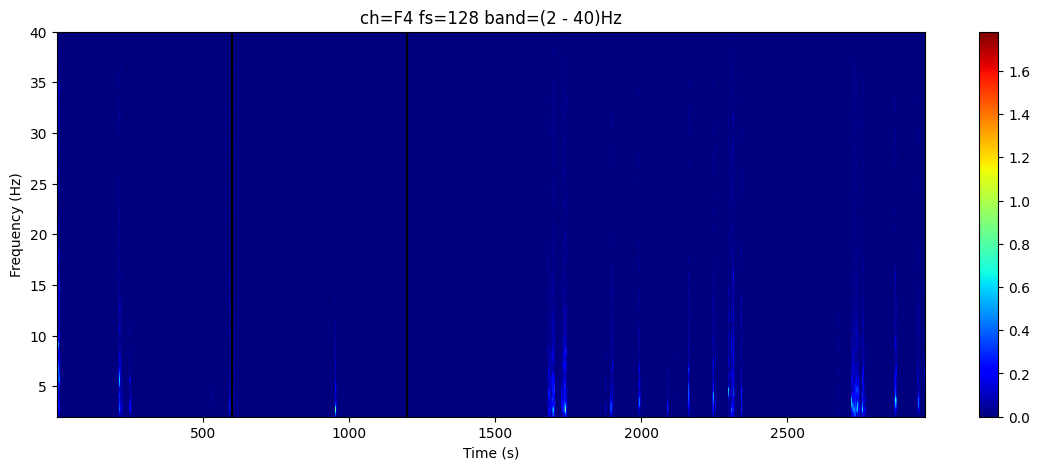

In [7]:
fft_spectogram = plot_spectrogram(example_data[channel], channel_name=channel, fs=128, fmin=2, fmax=40)

In [8]:

def plot_bins_spectogram2(data, fs, channels, bins, annotate=True):
    # plot the spectrogram
    fig, ax = plt.subplots(figsize=(14, 5))
    Sxx, freqs, _, _ = ax.specgram(
        data,
        # NFFT=2048*4,
        Fs=fs,
        # noverlap=1024,
        cmap='jet',
    )
    # Sxx = Sxx[:63, :]
    # bin_sxx = np.zeros((4, bins))
    Sxx = Sxx[14:32, :]
    bin_sxx = np.zeros((1, bins))
    window = len(Sxx[0])//bins

    # dict to array
    for ch_i, (f_min, f_max) in enumerate(channels.values()):
        if ch_i != 2:
            continue
        ch_i = 0
        for i in range(bins):
            bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:(i+1)*window])
        bin_sxx[ch_i] = normalize_arr(bin_sxx[ch_i])

    # bin_sxx = normalize_columns(bin_sxx)

    # if not plot:
    #     return bin_sxx

    im = ax.imshow(
        bin_sxx,
        cmap='jet',
        aspect='auto',
        origin='lower',
        vmin=np.min(bin_sxx),
        vmax=np.max(bin_sxx),
        )
    # ax.set_yticks(np.arange(len(channels)), labels=channels.keys())

    # Loop over data dimensions and create text annotations.
    if annotate:
        for i, _ in enumerate(channels):
            for j, _ in enumerate(bin_sxx[i]):
                text = ax.text(j, i, f'{bin_sxx[i, j]:.4f}',
                               rotation=90,
                               ha="center", va="center", color="white")

    ax.set_title("FFT spectogram")
    fig.tight_layout()
    fig.colorbar(im, ax=ax, label='Interactive colorbar')
    plt.show()
    return bin_sxx

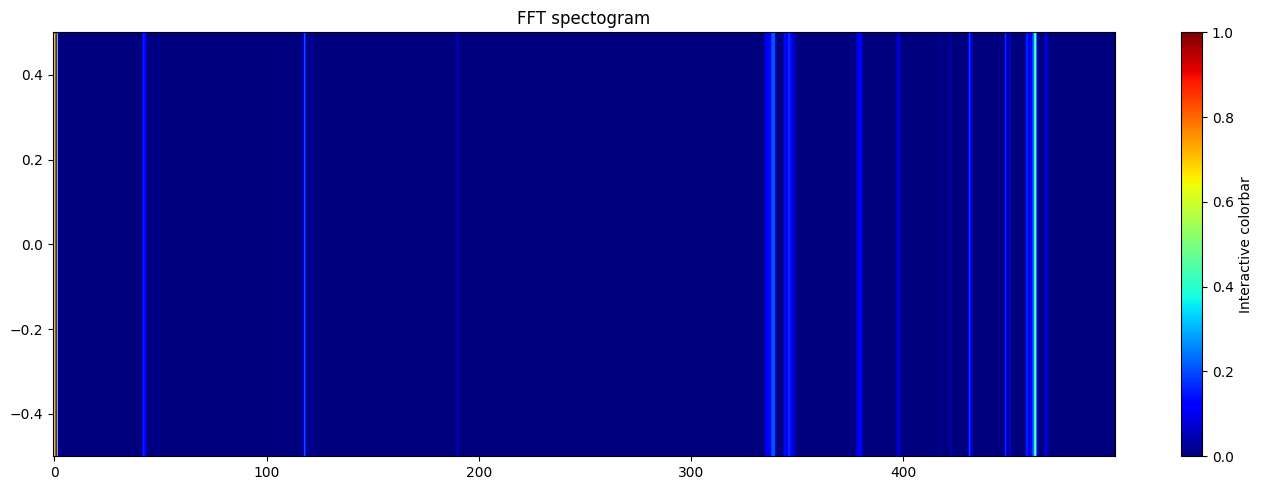

(1, 500)

In [9]:

def plot_bins_spectogram(data, fs, channels, bins, annotate=True):
    # plot the spectrogram
    fig, ax = plt.subplots(figsize=(14, 5))
    Sxx, freqs, _, _ = ax.specgram(
        data,
        # NFFT=2048*4,
        Fs=fs,
        # noverlap=1024,
        cmap='jet',
    )
    Sxx = Sxx[:63, :]
    bin_sxx = np.zeros((4, bins))
    window = len(Sxx[0])//bins

    # dict to array
    for ch_i, (f_min, f_max) in enumerate(channels.values()):
        for i in range(bins):
            bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:(i+1)*window]) / (f_max - f_min)
        bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:])
        bin_sxx[ch_i] = normalize_arr(bin_sxx[ch_i])

    # bin_sxx = standarize_arr(bin_sxx)
    # bin_sxx = normalize_columns(bin_sxx)


    # if not plot:
    #     return bin_sxx

    im = ax.imshow(
        bin_sxx,
        cmap='jet',
        aspect='auto',
        origin='lower',
        vmin=np.min(bin_sxx),
        vmax=np.max(bin_sxx),
        )
    ax.set_yticks(np.arange(len(channels)), labels=channels.keys())

    # Loop over data dimensions and create text annotations.
    if annotate:
        for i, _ in enumerate(channels):
            for j, _ in enumerate(bin_sxx[i]):
                text = ax.text(j, i, f'{bin_sxx[i, j]:.4f}',
                               rotation=90,
                               ha="center", va="center", color="white")

    ax.set_title("FFT spectogram")
    fig.tight_layout()
    fig.colorbar(im, ax=ax, label='Interactive colorbar')
    plt.show()
    return bin_sxx



def fft_spectogram2bins(Sxx, bins):
    bin_sxx = np.zeros((4, bins))
    window = len(Sxx[0])//bins

    # dict to array
    for ch_i, (f_min, f_max) in enumerate(channels.values()):
        for i in range(bins):
            bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:(i+1)*window]) / (f_max - f_min)
        bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:]) / (f_max - f_min)

    bin_sxx = bin_sxx
    return normalize_columns(bin_sxx)


channels = {
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 32),
    'gamma': (32, 60),
}
x = plot_bins_spectogram2(example_data[channel], fs=128, channels=channels, bins=500, annotate=False)
x.shape

In [89]:
bins

251

In [90]:
experiment_time = len(example_data[channel])/128
for window in [200_000, 100_000, 50_000, 25_000, 12_500, 6_250]:

    eeg_bands = spikes_data2eeg_bands(all_spikes2bins(example_spikes_channel, window=window))
    spikes_spectogram = spikes_dict2spectogram(eeg_bands)
    bins=int(spikes_spectogram.shape[1])
    fft_bin_spectogram = fft_spectogram2bins(fft_spectogram, bins)

    fft_bin_spectogram = fft_bin_spectogram[:, int(len(fft_bin_spectogram)/4):]
    spikes_spectogram = spikes_spectogram[:, int(len(spikes_spectogram)/4):]

    fft_window = len(fft_bin_spectogram[0]) / len(fft_spectogram[0])
    spikes_window = len(example_spikes_channel['08.000']) / len(spikes_spectogram[0])

    # Define two matrices
    matrix1 = fft_bin_spectogram
    matrix2 = spikes_spectogram

    # Flatten the matrices and calculate the correlation coefficient
    correlation_coefficient = np.corrcoef(matrix1.flatten(), matrix2.flatten())[0, 1]
    print(f"bins={bins} | time_window={experiment_time/bins:.3f}s | spikes_window {spikes_window:.3f} | fft_window {fft_window:.3f} | Corr={correlation_coefficient:.3f}")


bins=126 | time_window=23.583s | spikes_window 200037.168 | fft_window 0.042 | Corr=0.116
bins=251 | time_window=11.838s | spikes_window 100018.584 | fft_window 0.084 | Corr=0.126
bins=501 | time_window=5.931s | spikes_window 50009.292 | fft_window 0.168 | Corr=0.311
bins=1001 | time_window=2.968s | spikes_window 25004.646 | fft_window 0.337 | Corr=0.147
bins=2001 | time_window=1.485s | spikes_window 12502.323 | fft_window 0.673 | Corr=0.011
bins=4001 | time_window=0.743s | spikes_window 6251.162 | fft_window 1.347 | Corr=-0.015


In [12]:
def compare_resonator_to_freq(raw_data, spikes_data):
    pass

trial = 4
channel = 'O1'

raw_data = get_trial_data(trial)[channel]
spikes_data = load_preprocessed_spikes(trial, channel)


In [10]:
example_data.columns

Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4'],
      dtype='object')

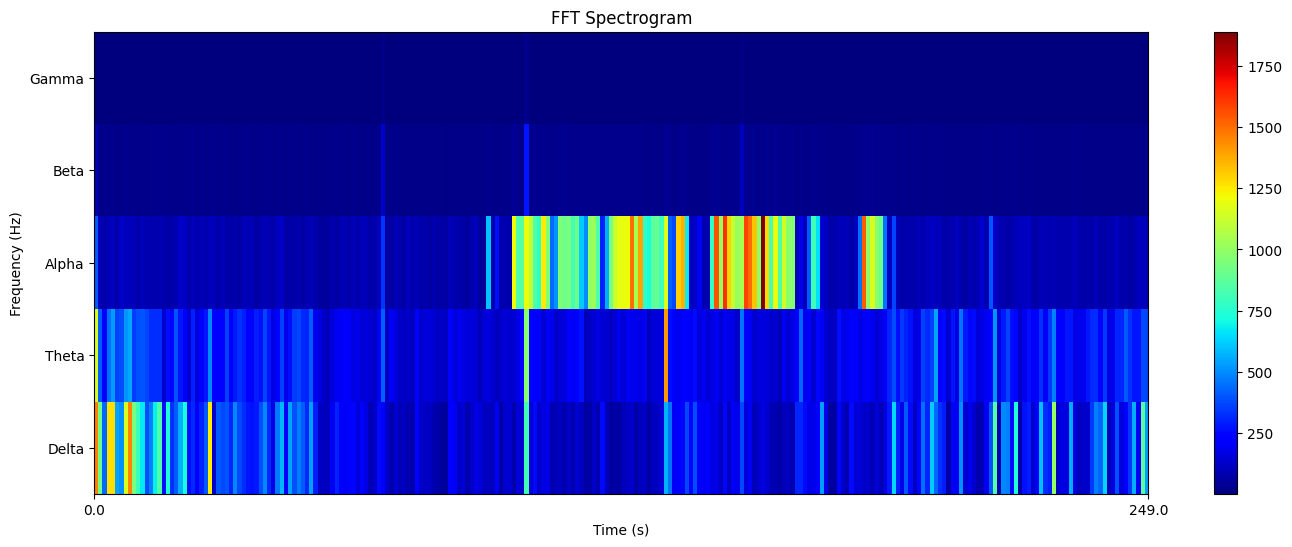

In [49]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(17, 6))

# Generate some example data
fs = 128  # Sampling frequency
# Compute the spectrogram with a colormap
Pxx, freqs, bins, im = plt.specgram(example_data['O1'], Fs=fs, cmap='magma')

# Define the frequency ranges for digitizing
freq_ranges = [0, 4, 8, 14, 32, 64]
freq_labels = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Define the number of x-axis bins
N = 250

# Compute the bin edges for the x-axis
x_edges = np.linspace(0, bins[-1], N + 1)

# Digitize the spectrogram
digitized = np.zeros((len(freq_ranges) - 1, N))
for i in range(N):
    x_start = x_edges[i]
    x_end = x_edges[i + 1]
    x_mask = np.logical_and(bins >= x_start, bins < x_end)
    for j in range(len(freq_ranges) - 1):
        freq_start = freq_ranges[j]
        freq_end = freq_ranges[j + 1]
        freq_mask = np.logical_and(freqs >= freq_start, freqs < freq_end)
        digitized[j, i] = np.sum(Pxx[freq_mask][:, x_mask]) / (freq_end- freq_start)

# Plot the digitized spectrogram
im = plt.imshow(digitized, extent=[x_edges[0], x_edges[-1], 0, len(freq_ranges) - 1],
           aspect='auto', origin='lower', cmap='jet')

# Add a colorbar
plt.colorbar(im)

# Set the y-tick labels to the frequency range labels
plt.yticks(np.arange(len(freq_labels)) + .5, freq_labels)
plt.xticks(np.linspace(0, Pxx.shape[1], N//100, dtype=int), np.linspace(0, N-1, N//100))


# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('FFT Spectrogram')

# Show the plot
plt.show()


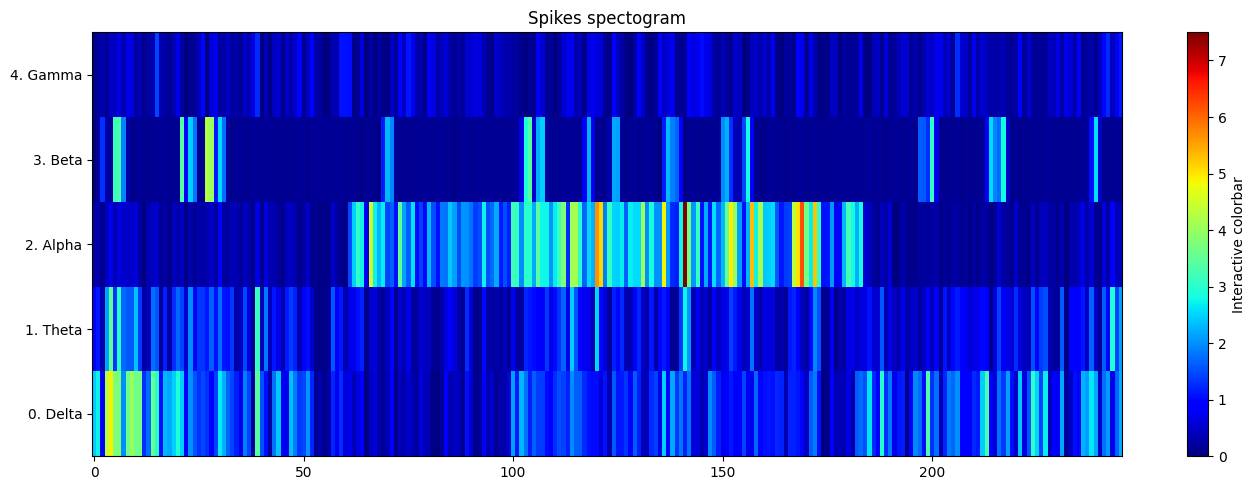

In [48]:
eeg_bands = spikes_data2eeg_bands(all_spikes2bins(spikes_data, window=100000))
spikes_spectogram = spikes_dict2spectogram(eeg_bands)
bins=int(spikes_spectogram.shape[1])
plot_heatmap(spikes_spectogram, eeg_bands.keys(), annotate=False, title='Spikes spectogram')

In [47]:

def spikes_data2eeg_bands(spikes_data):

    def normalize(freqs, alpha, spec):
        if freqs == ['10.072', '09.065']:
            remove_dc = []
            for f in freqs:
                data = spikes_data[f][:-5]
                data[len(data)//4:3*len(data)//4] *= 2
                data = data - min(data)
                remove_dc.append(data)
            # remove_dc = [(spikes_data[f][:-5] - np.min(spikes_data[f][:-5])) for f in freqs]
        elif freqs == ['01.523', '02.120', '03.490']:
            remove_dc = []
            for f in freqs:
                data = spikes_data[f][:-5]
                data[len(data)//4:3*len(data)//4] = data[len(data)//4:3*len(data)//4]/1.1
                data = data - min(data)
                remove_dc.append(data)
        else:
            remove_dc = [(spikes_data[f][:-5] - np.min(spikes_data[f][:-5])) for f in freqs]
        _normalize = [(f / np.mean(f)) ** 2  for f in remove_dc]
        aggregate_channel = np.sum(_normalize, axis=0)/len(freqs)
        return aggregate_channel / spec #*alpha #/spec #* np.log10(10*alpha/2)

    return {
        # ['00.657', '01.523', '02.120', '02.504', '03.490']
        '0. Delta': normalize(['01.523', '02.120', '03.490'], 1, 1),
        '1. Theta': normalize(['08.000', '05.755'], 5.25, 1.5),
        '2. Alpha': normalize(['10.072', '09.065'], 9.2, 1),
        '3. Beta':  normalize(['15.108'], 19.7, 3),
        '4. Gamma': normalize(['36.259'], 41.37, 3),

    }


def normalize_columns(arr):
    column_sums = np.sum(arr, axis=0)
    normalized = arr / column_sums[np.newaxis, :]
    return normalized


def spikes_dict2spectogram(
        output_spikes,
):
    spikes_heatmap = pd.DataFrame.from_dict(output_spikes)
    spikes_heatmap = spikes_heatmap.reindex(sorted(spikes_heatmap.columns), axis=1).T
    spikes_heatmap_data = spikes_heatmap.to_numpy()

    # spikes_heatmap_data = normalize_columns(spikes_heatmap_data)
    return spikes_heatmap_data


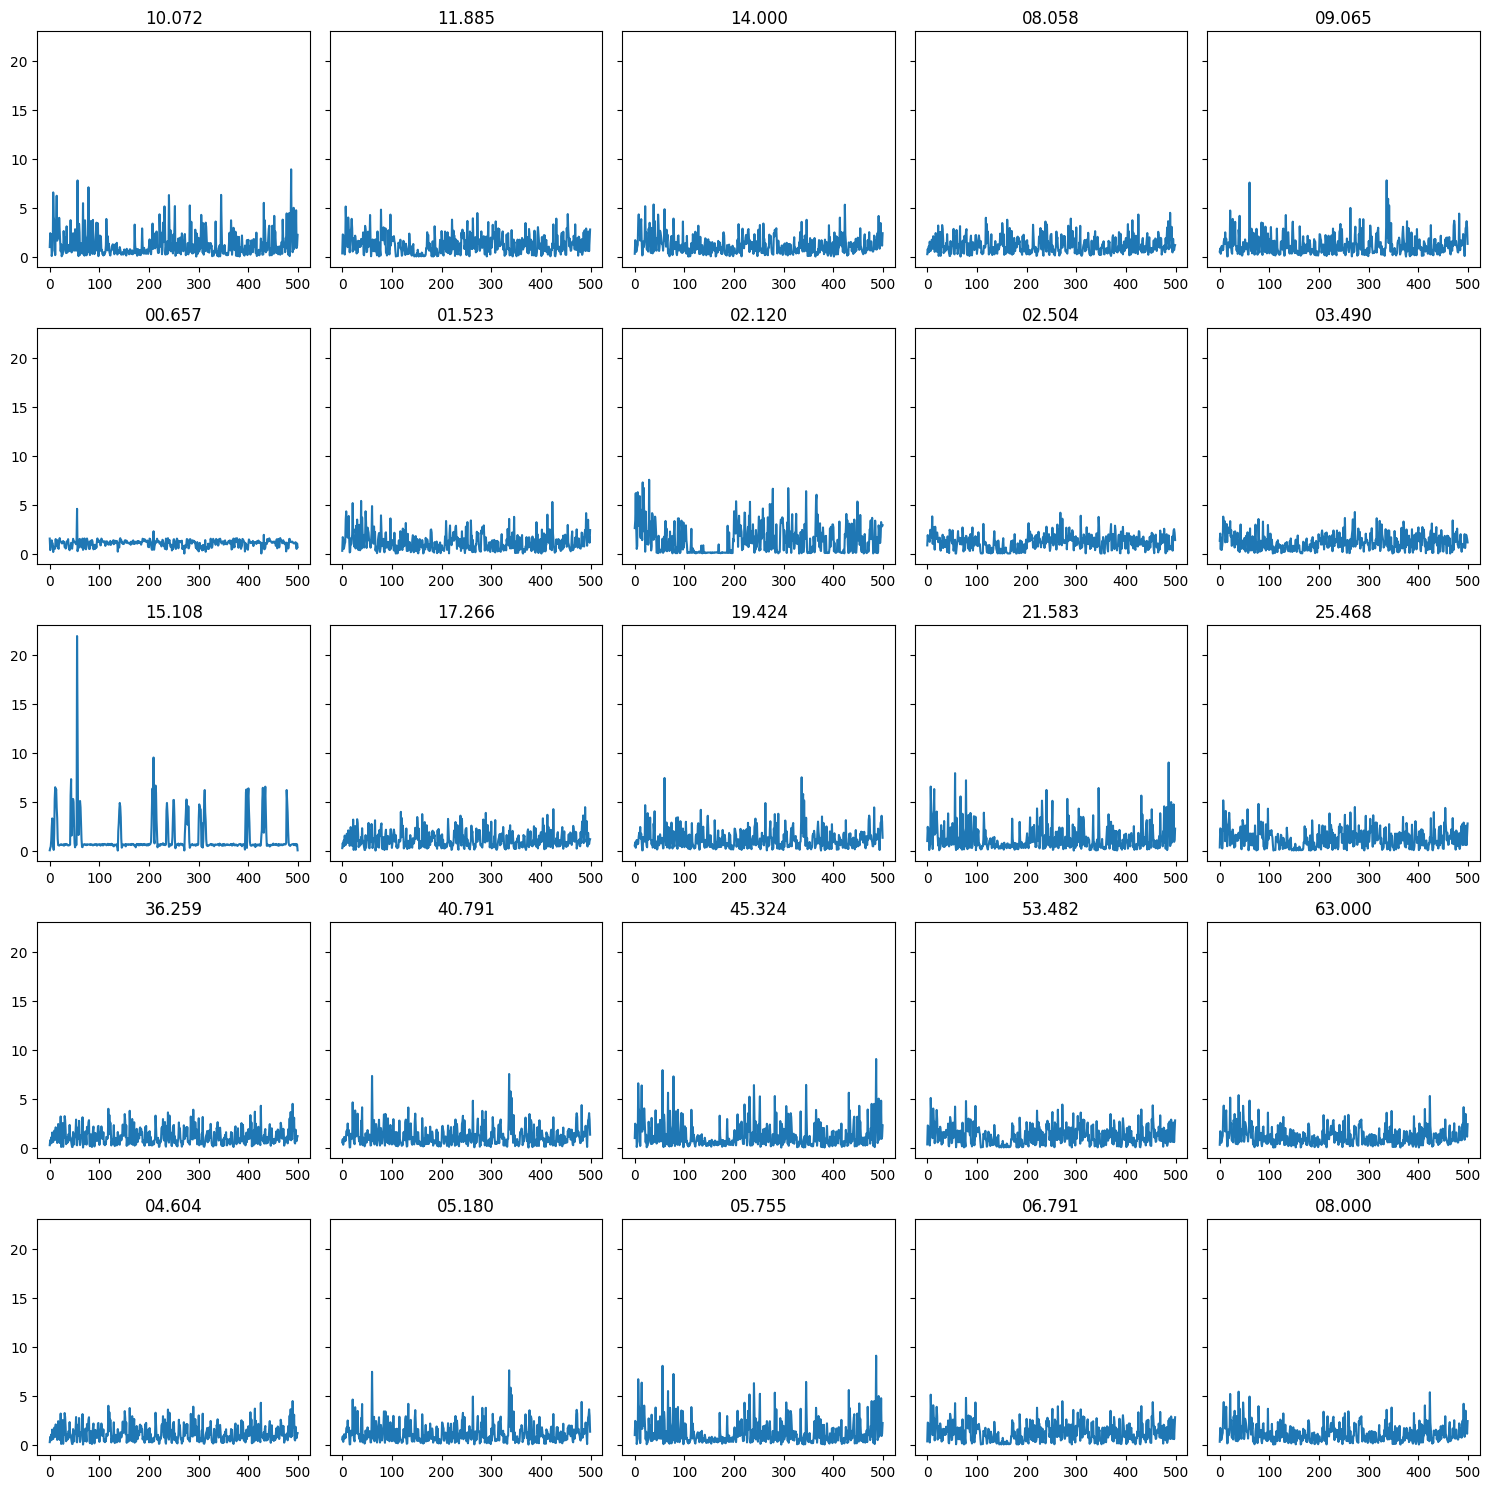

In [21]:
from scipy.signal import convolve

# Define the size of the subplot grid
nrows, ncols = 5, 5

# Define the convolution kernel
kernel = np.ones(10000)

# Create a figure with subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15), sharey=True)
N = 500

# Iterate over the dictionary and plot the arrays
for i, (key, data) in enumerate(spikes_data.items()):
    # Apply the convolution
    bin_size = len(data) // N

    # conv_data = convolve(data, kernel, mode='same')
    data = np.sum(data[:bin_size*N].reshape((N, bin_size)), axis=1)
    data = data - np.min(data)
    data = data / np.mean(data)
    data = data ** 2
    # data = (conv_data - np.mean(conv_data)) / np.std(conv_data)
    # Calculate the row and column index of the current subplot
    row_idx, col_idx = i // ncols, i % ncols

    # Plot the data
    axs[row_idx, col_idx].plot(data)
    axs[row_idx, col_idx].set_title(key)

# Adjust the layout of the subplots and show the plot
plt.tight_layout()
plt.show()

In [179]:
len(spikes_data)

25

In [54]:
def multiply(a, b):
    return a * b

def beep(s):
    return str(s) + ' beep.'

def factorial(a):
    res = 1
    for i in range(1, a+1):
        res *= i
    return res

def yakir_ex(x1, x2):
    f1 = factorial(x1)
    f2 = factorial(x2)
    m = multiply(f1, f2)
    return beep(m)

In [55]:
a = 3
b = 4
yakir_ex(a, b)

'144 beep.'